# Define Problem Statement and perform Exploratory Data Analysis (10 Points)
## Problem Statement
The goal is to analyze delivery trip data, perform feature engineering, handle missing values and outliers, and provide business insights. 

## Objectives:
- Exploratory Data Analysis
- Feature creation and aggregation
- Comparison of time and distance fields
- Missing value and outlier treatment
- Handling categorical values
- Column normalization/standardization
- Business insights and recommendations


In [1]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Load the CSV data from the provided Google Drive link
url = 'https://drive.google.com/uc?export=download&id=1hsQ21PYKhhcUUY_82C_Fv2CwWRDRMgV1'

# Read the data into a DataFrame and inspect basic information
data = pd.read_csv(url)

# Display info about the dataset
data.info()

# Display column names
data.columns

# Display shape and check for missing values
data.shape
data.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
is_cutoff                           0
cutoff_factor                       0
cutoff_timestamp                    0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
factor                              0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
segment_factor                      0
dtype: int64

In [3]:
# Drop irrelevant columns and handle missing values
data_cleaned = data.drop(['is_cutoff', 'cutoff_factor', 'cutoff_timestamp', 'segment_factor'], axis=1)
data_cleaned = data_cleaned.dropna(how='any').reset_index(drop=True)

# Add a new column 'segment_key' by concatenating 'trip_uuid', 'source_center', and 'destination_center'
data_cleaned['segment_key'] = data_cleaned['trip_uuid'] + data_cleaned['source_center'] + data_cleaned['destination_center']

# Define columns for calculating cumulative sums
segment_cols = ['segment_actual_time', 'segment_osrm_distance', 'segment_osrm_time']

# Calculate cumulative sums for each segment identified by 'segment_key'
for col in segment_cols:
    data_cleaned[col + '_sum'] = data_cleaned.groupby('segment_key')[col].cumsum()

# Extract the cumulative sum columns
cumulative_sum_columns = data_cleaned[[col + '_sum' for col in segment_cols]]


In [4]:
# Create dictionary for aggregation at segment level
create_segment_dict = {
    'data': 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid': 'first',
    'route_type': 'first',
    'trip_uuid': 'first',
    'source_center': 'first',
    'source_name': 'first',
    'destination_center': 'last',
    'destination_name': 'last',
    'od_start_time': 'first',
    'od_end_time': 'first',
    'start_scan_to_end_scan': 'first',
    'actual_distance_to_destination': 'last',
    'actual_time': 'last',
    'osrm_time': 'last',
    'osrm_distance': 'last',
    'segment_actual_time_sum': 'last',
    'segment_osrm_distance_sum': 'last',
    'segment_osrm_time_sum': 'last',
}

# Aggregate data at segment level
segment = data_cleaned.groupby('segment_key').agg(create_segment_dict).reset_index()

# Sort the aggregated data by 'segment_key' and 'od_end_time'
segment = segment.sort_values(by=['segment_key', 'od_end_time'], ascending=True).reset_index(drop=True)

# Convert 'od_start_time' and 'od_end_time' to datetime format
segment['od_start_time'] = pd.to_datetime(segment['od_start_time'])
segment['od_end_time'] = pd.to_datetime(segment['od_end_time'])

# Calculate the time difference in minutes between 'od_start_time' and 'od_end_time'
segment['od_time_diff_hour'] = (segment['od_end_time'] - segment['od_start_time']).dt.total_seconds() / 60


In [5]:
# Create dictionary for aggregation at trip level
create_trip_dict = {
    'data': 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid': 'first',
    'route_type': 'first',
    'trip_uuid': 'first',
    'source_center': 'first',
    'source_name': 'first',
    'destination_center': 'last',
    'destination_name': 'last',
    'start_scan_to_end_scan': 'sum',
    'od_time_diff_hour': 'sum',
    'actual_distance_to_destination': 'sum',
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'segment_actual_time_sum': 'sum',
    'segment_osrm_distance_sum': 'sum',
    'segment_osrm_time_sum': 'sum',
}

# Aggregate data at trip level
trip = segment.groupby('trip_uuid').agg(create_trip_dict).reset_index(drop=True)


In [6]:
# Lowercase source and destination names
trip['destination_name'] = trip['destination_name'].str.lower()
trip['source_name'] = trip['source_name'].str.lower()

# Define helper functions to extract state, city, place, and code
def place2state(x):
    return x.split('(')[1][:-1]

def place2city(x):
    city = x.split(' (')[0].split('_')[0]
    return {
        'pnq vadgaon sheri dpc': 'vadgaonsheri',
        'pnq pashan dpc': 'pune',
        'pnq rahatani dpc': 'pune',
        'pune balaji nagar': 'pune',
        'hbr layout pc': 'bengaluru',
        'bhopal mp nagar': 'bhopal',
        'mumbai antop hill': 'mumbai',
    }.get(city, city)

def place2city_place(x):
    return x.split(' (')[0].split('_')[1] if len(x.split('_')) >= 2 else x.split(' ')[0]

def place2code(x):
    return x.split(' (')[0].split('_')[-1] if len(x.split('_')) >= 2 else 'none'

# Apply these functions to source and destination columns
trip['destination_state'] = trip['destination_name'].apply(place2state)
trip['destination_city'] = trip['destination_name'].apply(place2city)
trip['destination_place'] = trip['destination_name'].apply(place2city_place)
trip['destination_code'] = trip['destination_name'].apply(place2code)

trip['source_state'] = trip['source_name'].apply(place2state)
trip['source_city'] = trip['source_name'].apply(place2city)
trip['source_place'] = trip['source_name'].apply(place2city_place)
trip['source_code'] = trip['source_name'].apply(place2code)


In [7]:
# Convert 'trip_creation_time' to datetime and extract time-based features
trip['trip_creation_time'] = pd.to_datetime(trip['trip_creation_time'])
trip['trip_year'] = trip['trip_creation_time'].dt.year
trip['trip_month'] = trip['trip_creation_time'].dt.month
trip['trip_hour'] = trip['trip_creation_time'].dt.hour
trip['trip_day'] = trip['trip_creation_time'].dt.day
trip['trip_week'] = trip['trip_creation_time'].dt.isocalendar().week
trip['trip_dayofweek'] = trip['trip_creation_time'].dt.dayofweek


### Insight:
We will now calculate the difference between the time difference from 'od_start_time' and 'od_end_time' (`od_time_diff_hour`) and 'start_scan_to_end_scan' to analyze any significant discrepancies between them.


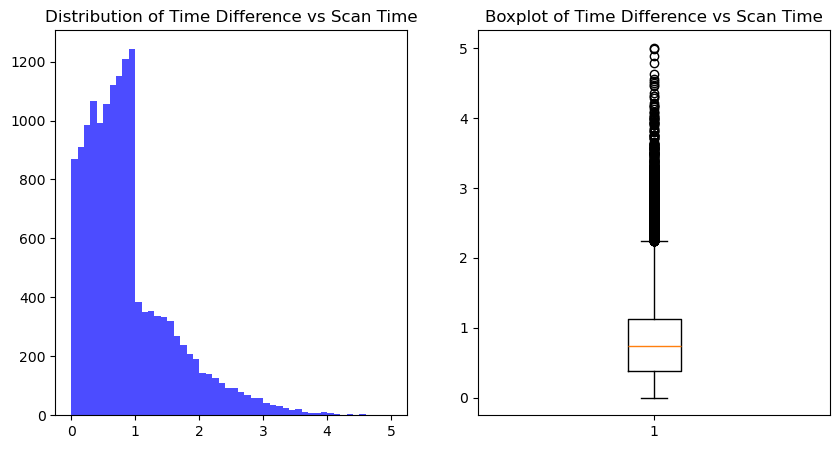

(153.03905412927918, 0.0)

In [8]:
# Calculate the time difference between 'od_time_diff_hour' and 'start_scan_to_end_scan'
trip['time_diff_vs_scan'] = trip['od_time_diff_hour'] - trip['start_scan_to_end_scan']

# Visualize the distribution and boxplot of time differences
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(trip['time_diff_vs_scan'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Time Difference vs Scan Time')

plt.subplot(1, 2, 2)
plt.boxplot(trip['time_diff_vs_scan'].dropna())
plt.title('Boxplot of Time Difference vs Scan Time')

plt.show()

# Perform a paired t-test to compare 'od_time_diff_hour' and 'start_scan_to_end_scan'
t_stat, p_value = stats.ttest_rel(trip['od_time_diff_hour'], trip['start_scan_to_end_scan'])

# Display t-statistic and p-value
t_stat, p_value


### Insight:
The paired t-test results provide insight into whether there is a statistically significant difference between the time recorded by scan time (`start_scan_to_end_scan`) and the calculated time difference (`od_time_diff_hour`).


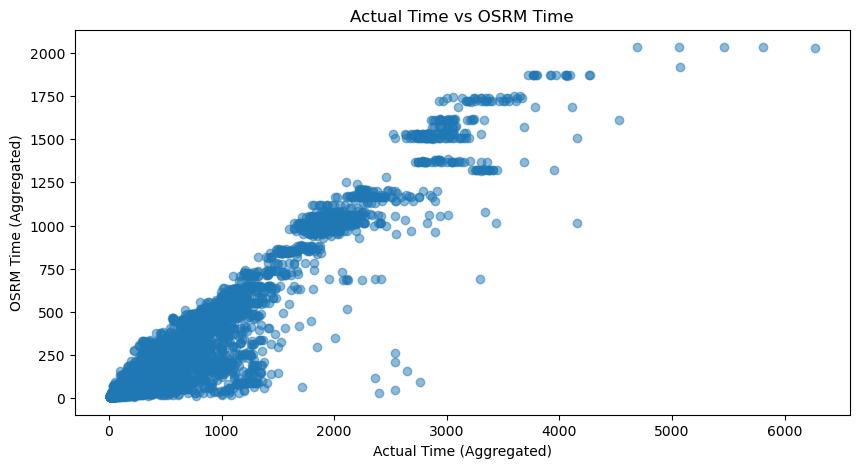

(76.37699387098537, 0.0)

In [9]:
# Scatter plot to compare actual time and OSRM time
plt.figure(figsize=(10, 5))
plt.scatter(trip['actual_time'], trip['osrm_time'], alpha=0.5)
plt.title('Actual Time vs OSRM Time')
plt.xlabel('Actual Time (Aggregated)')
plt.ylabel('OSRM Time (Aggregated)')
plt.show()

# Perform a paired t-test between actual_time and osrm_time
t_stat_osrm, p_value_osrm = stats.ttest_rel(trip['actual_time'], trip['osrm_time'])

# Display t-statistic and p-value
t_stat_osrm, p_value_osrm


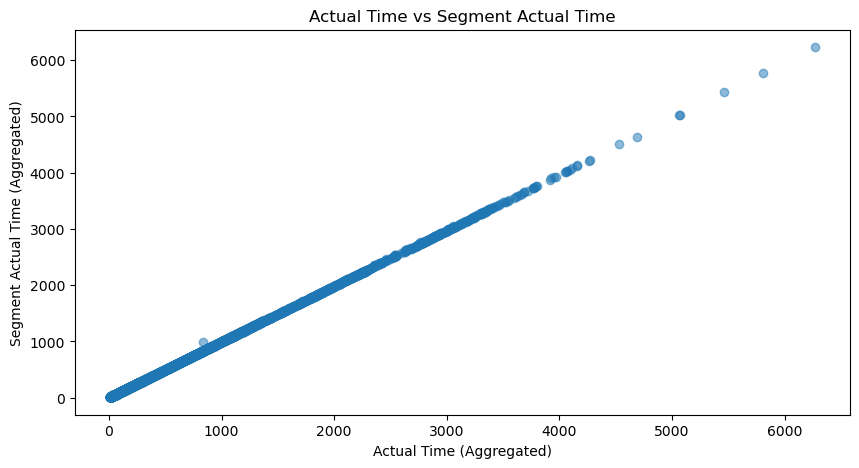

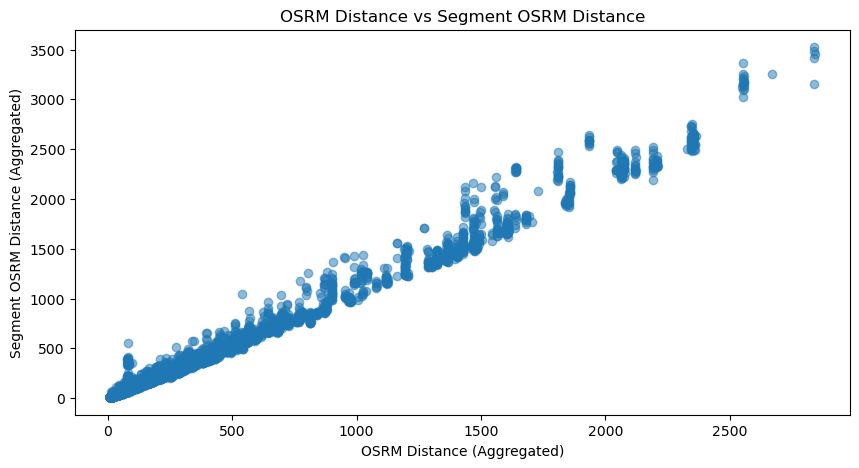

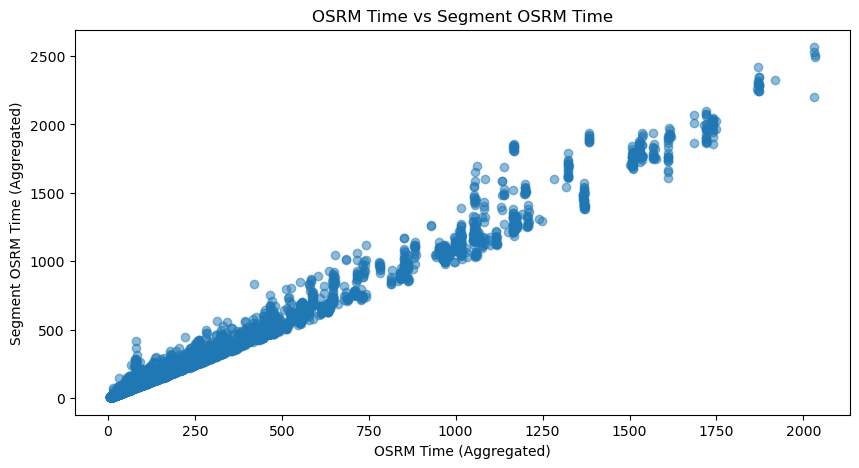

In [10]:
# Scatter plot and paired t-test: Actual Time vs Segment Actual Time
plt.figure(figsize=(10, 5))
plt.scatter(trip['actual_time'], trip['segment_actual_time_sum'], alpha=0.5)
plt.title('Actual Time vs Segment Actual Time')
plt.xlabel('Actual Time (Aggregated)')
plt.ylabel('Segment Actual Time (Aggregated)')
plt.show()

t_stat_segment_actual, p_value_segment_actual = stats.ttest_rel(trip['actual_time'], trip['segment_actual_time_sum'])

# Scatter plot and paired t-test: OSRM Distance vs Segment OSRM Distance
plt.figure(figsize=(10, 5))
plt.scatter(trip['osrm_distance'], trip['segment_osrm_distance_sum'], alpha=0.5)
plt.title('OSRM Distance vs Segment OSRM Distance')
plt.xlabel('OSRM Distance (Aggregated)')
plt.ylabel('Segment OSRM Distance (Aggregated)')
plt.show()

t_stat_segment_osrm_distance, p_value_segment_osrm_distance = stats.ttest_rel(trip['osrm_distance'], trip['segment_osrm_distance_sum'])

# Scatter plot and paired t-test: OSRM Time vs Segment OSRM Time
plt.figure(figsize=(10, 5))
plt.scatter(trip['osrm_time'], trip['segment_osrm_time_sum'], alpha=0.5)
plt.title('OSRM Time vs Segment OSRM Time')
plt.xlabel('OSRM Time (Aggregated)')
plt.ylabel('Segment OSRM Time (Aggregated)')
plt.show()

t_stat_segment_osrm_time, p_value_segment_osrm_time = stats.ttest_rel(trip['osrm_time'], trip['segment_osrm_time_sum'])


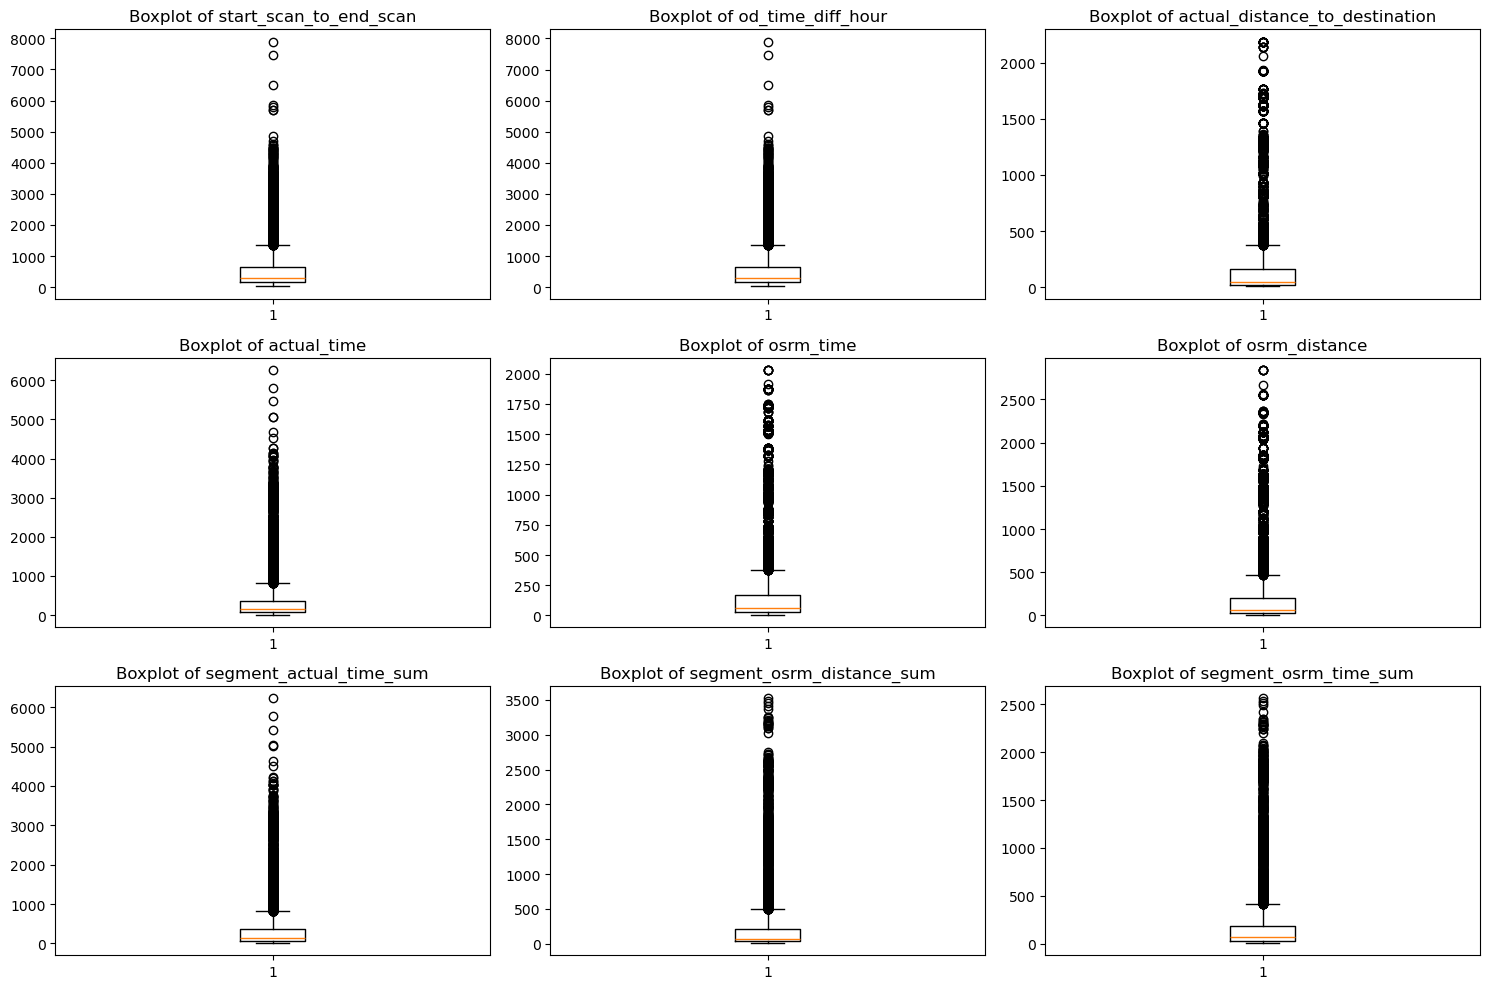

In [11]:
# Identify and visualize outliers using boxplots for numerical columns
numerical_columns = ['start_scan_to_end_scan', 'od_time_diff_hour', 'actual_distance_to_destination', 
                     'actual_time', 'osrm_time', 'osrm_distance', 'segment_actual_time_sum', 
                     'segment_osrm_distance_sum', 'segment_osrm_time_sum']

# Visualizing outliers using boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(trip[col].dropna())
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Handle outliers using the IQR method
Q1 = trip[numerical_columns].quantile(0.25)
Q3 = trip[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Remove rows that contain outliers
trip_no_outliers = trip[~((trip[numerical_columns] < (Q1 - 1.5 * IQR)) | (trip[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [12]:
# One-Hot Encoding for categorical columns
trip_encoded = pd.get_dummies(trip_no_outliers, columns=['route_type'], drop_first=True)

# Normalize numerical columns using MinMaxScaler
scaler = MinMaxScaler()
scaled_columns = numerical_columns
trip_scaled = trip_encoded.copy()

trip_scaled[scaled_columns] = scaler.fit_transform(trip_encoded[scaled_columns])

# Display final processed DataFrame after outlier handling and scaling
trip_scaled.head()


,data,trip_creation_time,route_schedule_uuid,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,od_time_diff_hour,...,source_place,source_code,trip_year,trip_month,trip_hour,trip_day,trip_week,trip_dayofweek,time_diff_vs_scan,route_type_FTL
1,training,2018-09-12 00:00:22.886430,thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...,trip-153671042288605164,IND561203AAB,doddablpur_chikadpp_d (karnataka),IND561203AAB,doddablpur_chikadpp_d (karnataka),0.117868,0.118559,...,chikadpp,d,2018,9,0,12,37,2,1.611874,False
3,training,2018-09-12 00:01:00.113710,thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...,trip-153671046011330457,IND400072AAB,mumbai hub (maharashtra),IND401104AAA,mumbai_mirard_ip (maharashtra),0.057808,0.057749,...,mumbai,none,2018,9,0,12,37,2,0.494935,False
4,training,2018-09-12 00:02:09.740725,thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...,trip-153671052974046625,IND583101AAA,bellary_dc (karnataka),IND583119AAA,sandur_wrdn1dpp_d (karnataka),0.521021,0.520930,...,dc,dc,2018,9,0,12,37,2,1.349042,True
5,training,2018-09-12 00:02:34.161600,thanos::sroute:9bf03170-d0a2-4a3f-aa4d-9aaab3d...,trip-153671055416136166,IND600056AAA,chennai_poonamallee (tamil nadu),IND600056AAA,chennai_poonamallee (tamil nadu),0.124625,0.125213,...,poonamallee,poonamallee,2018,9,0,12,37,2,1.487849,False
6,training,2018-09-12 00:04:22.011653,thanos::sroute:a97698cc-846e-41a7-916b-88b1741...,trip-153671066201138152,IND600044AAD,chennai_chrompet_dpc (tamil nadu),IND600048AAA,chennai_vandalur_dc (tamil nadu),0.056306,0.055883,...,chrompet,dpc,2018,9,0,12,37,2,0.005634,False


## Recomendation :

There is a significant difference between OSRM and actual parameters.

### There is a need to:


Revisit information fed to routing engine for trip planning.
Check for discrepancies with transporters, if the routing engine is configured for optimum results.


North, South and West Zones corridors have significant traffic of orders. But, we have a smaller presence in Central, Eastern and North-Eastern zone. However it would be difficult to conclude this, by looking at just 2 months data. It is worth investigating and increasing our presence in these regions.


From state point of view, we have heavy traffic in Mahrashtra followed by Karnataka. This is a good indicator that we need to plan for resources on ground in these 2 states on priority. Especially, during festive seasons.